In [1]:
# dependencies
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import zarr
from sklearn.metrics import r2_score
import dask

from fastjmd95 import jmd95numba 
from xhistogram.xarray import histogram
import cmocean
from pathlib import Path

In [2]:
data_dir = '/orcd/data/abodner/002/cody/MLD_per_pixel'
data1 = 'MLD_1_(432,9192)_Agulhas'
data2 ='MLD_2_zarr_storage_rerun_(432,9192)_Agulhas'
MLD_1 = xr.open_zarr(f'{data_dir}/{data1}.zarr',consolidated=False)
#MLD_2 = xr.open_zarr(f'{data_dir}/{data2}.zarr',consolidated=False)
#llc = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

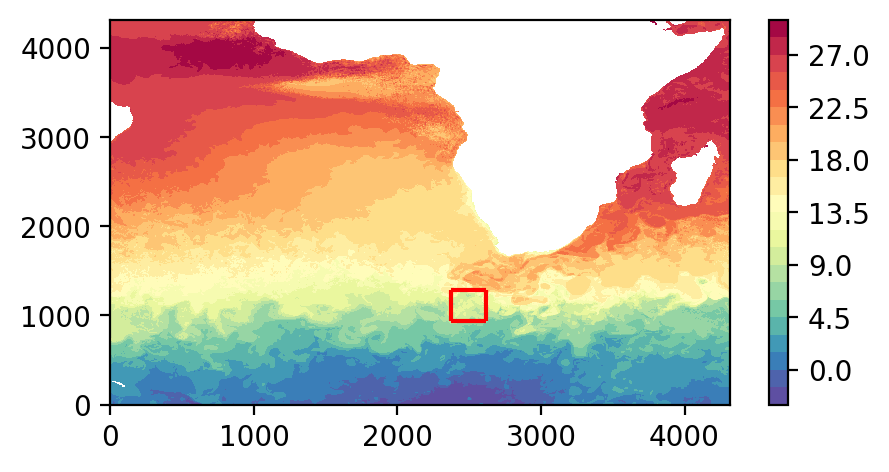

In [3]:
t1 = MLD_1.isel(time=0)
# extract box i,j extents
i_0 = t1.i.values.min()
i_1 = t1.i.values.max()
j_0 = t1.j.values.min()
j_1 = t1.j.values.max()
# j_0 = 800
# j_1 = j_0 + 540
# i_0 = 2500
# i_1 = i_0 + 540

# let's visualize loc of interest
llc_vis = llc.isel(time=2000,face=1, k=14)
fig, ax = plt.subplots(figsize=(5,2.5),dpi=200)
cf = ax.contourf(llc_vis['Theta']['i'], llc_vis['Theta']['j'], llc_vis['Theta'], cmap="Spectral_r",vmin=np.min(llc_vis['Theta']).values,vmax=np.max(llc_vis['Theta']).values, levels = 30)

ax.hlines(y=j_0, xmin=i_0, xmax=i_1, colors='r')
ax.hlines(y=j_1, xmin=i_0, xmax=i_1, colors='r')
ax.vlines(x=i_0, ymin=j_0, ymax=j_1, colors='r')
ax.vlines(x=i_1, ymin=j_0, ymax=j_1, colors='r')

plt.colorbar(cf, ax = ax)
ax.set_xlim(0,4320)

plt.show()

In [4]:
MLD_tiles_1 = MLD_1['MLD_pixels']
MLD_tiles_2 = MLD_2['MLD_pixels']

In [ ]:
sep_1 = MLD_tiles_1.isel(time=-1)
sep_2 = MLD_tiles_2.isel(time=-1)

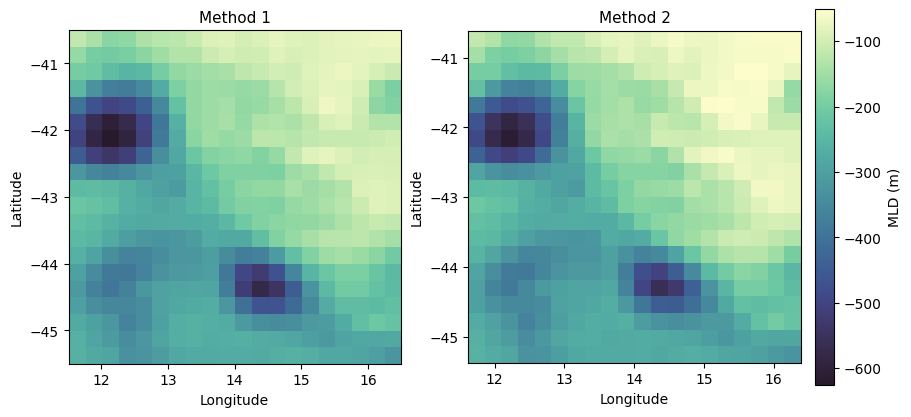

In [6]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(9, 4.5), constrained_layout=True
)

# shared color limits
vmin = np.nanmin([sep_1.min(), sep_2.min()])
vmax = np.nanmax([sep_1.max(), sep_2.max()])

im1 = ax1.imshow(
    sep_1,
    extent=[
        float(MLD_1.XC.min()), float(MLD_1.XC.max()),
        float(MLD_1.YC.min()), float(MLD_1.YC.max()),
    ],
    origin="lower",
    cmap=cmocean.cm.deep_r,
    vmin=vmin,
    vmax=vmax,
)

im2 = ax2.imshow(
    sep_2,
    extent=[
        float(MLD_2.XC.min()), float(MLD_2.XC.max()),
        float(MLD_2.YC.min()), float(MLD_2.YC.max()),
    ],
    origin="lower",
    cmap=cmocean.cm.deep_r,
    vmin=vmin,
    vmax=vmax,
)

# titles
ax1.set_title("Method 1", fontsize=11)
ax2.set_title("Method 2", fontsize=11)

# labels
for ax in (ax1, ax2):
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect("equal")

# single colorbar
cbar = fig.colorbar(im2, ax=[ax1, ax2], shrink=0.85, pad=0.02)
cbar.set_label("MLD (m)")

plt.show()

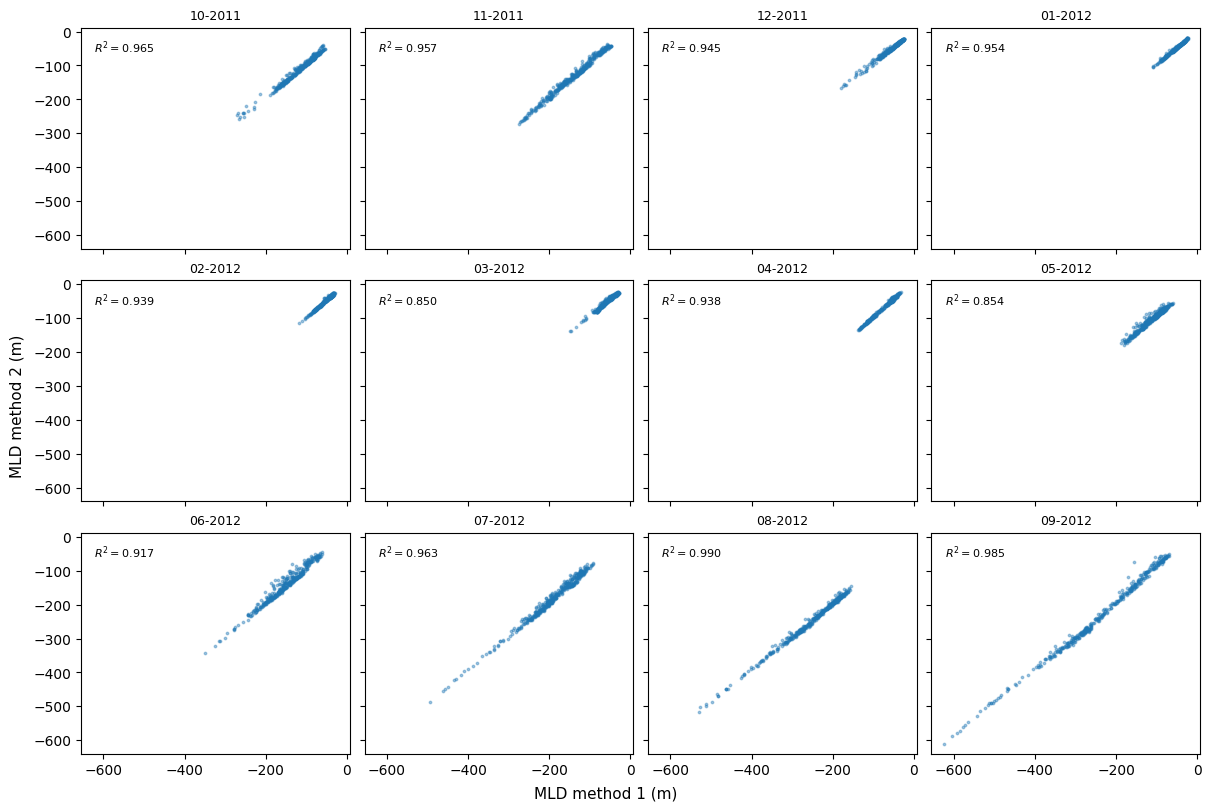

In [7]:
fig, axes = plt.subplots(
    3, 4,
    figsize=(12, 8),
    sharex=True,
    sharey=True,
    constrained_layout=True
)

axes = axes.ravel()

for n, month in enumerate(MLD_tiles_1.time.values):
    ax = axes[n]

    month_str = pd.to_datetime(month).strftime('%m-%Y')

    flat_1 = MLD_tiles_1.isel(time=n).values.flatten()
    flat_2 = MLD_tiles_2.isel(time=n).values.flatten()

    mask = np.isfinite(flat_1) & np.isfinite(flat_2)
    r2 = r2_score(flat_1[mask], flat_2[mask])

    ax.scatter(flat_1, flat_2, s=3, alpha=0.4)

    ax.set_title(month_str, fontsize=9)

    ax.text(
        0.05, 0.95,
        f"$R^2={r2:.3f}$",
        transform=ax.transAxes,
        va="top",
        fontsize=8
    )

# global labels
fig.supxlabel("MLD method 1 (m)", fontsize=11)
fig.supylabel("MLD method 2 (m)", fontsize=11)

plt.show()

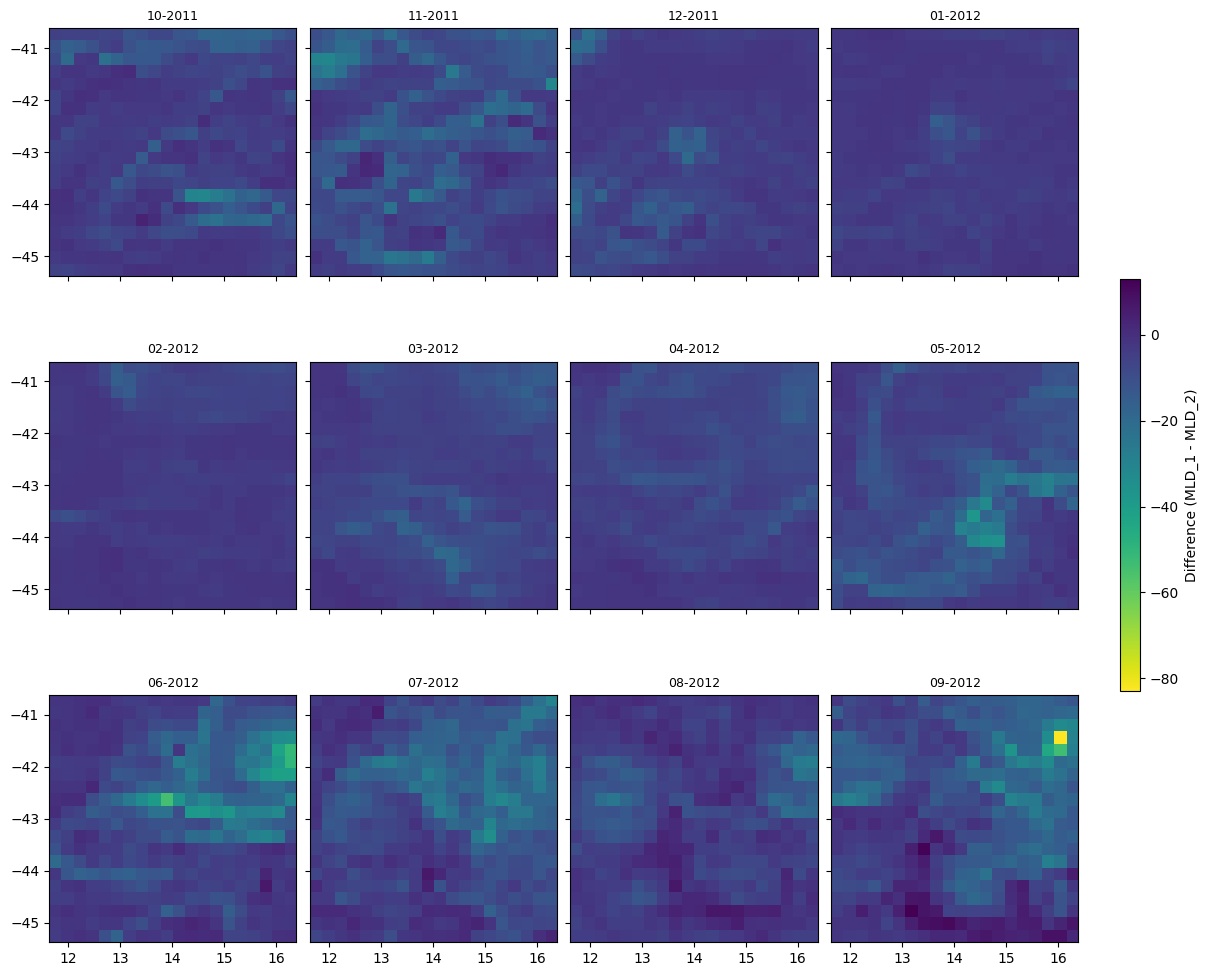

In [8]:
fig, axes = plt.subplots(
    3, 4,
    figsize=(12, 10), # Slightly taller to accommodate cbar
    sharex=True,
    sharey=True,
    constrained_layout=True
)

axes_flat = axes.ravel()

# 1. Determine global min/max for a consistent scale
diff = MLD_tiles_1 - MLD_tiles_2
v_min, v_max = float(diff.min()), float(diff.max())

for n, month in enumerate(MLD_tiles_1.time.values):
    ax = axes_flat[n]
    month_str = pd.to_datetime(month).strftime('%m-%Y')

    # 2. Pass vmin and vmax so the colors are comparable
    im = ax.imshow(
        diff.isel(time=n),
        extent=[
            float(MLD_2.XC.min()), float(MLD_2.XC.max()),
            float(MLD_2.YC.min()), float(MLD_2.YC.max()),
        ],
        origin="lower",
        cmap='viridis_r',
        vmin=v_min, 
        vmax=v_max
    )
    
    ax.set_title(month_str, fontsize=9)

# 3. Create the universal colorbar
# We use 'axes' (the 2D array) to tell matplotlib to steal space from the whole grid
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Difference (MLD_1 - MLD_2)', fontsize=10)

plt.show()

In [2]:
# for Kuroshio
def rotate_axes_90_clockwise(ax):
    """
    Robustly rotate a Matplotlib Axes 90 degrees clockwise by:
      - rendering the figure to an RGBA buffer,
      - cropping the pixels belonging to the given Axes,
      - rotating the image 90 deg clockwise,
      - placing the rotated image back into the figure at the same axes position,
      - removing the original Axes.

    Notes:
    - This rasterizes the axis contents (the result is an image, not vector art).
    - Colorbars or other axes that live outside the target `ax` are left alone.
    - Works reliably for full grids or arbitrary subsets.
    """
    fig = ax.figure

    # Force draw so renderer & sizes are correct
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    # Get pixel bbox of the axes (in display coordinates) via renderer-aware call
    bbox = ax.get_window_extent(renderer=renderer)  # Bbox in display (pixel) coords

    # Grab the full figure RGBA buffer (H x W x 4)
    buf = np.asarray(renderer.buffer_rgba())  # returns an (H,W,4) uint8 array

    H, W = buf.shape[0], buf.shape[1]

    # Convert bbox to integer pixel coords and crop.
    # Note: Bbox y coords are in display coordinates with origin at lower-left.
    x0, x1 = int(np.floor(bbox.x0)), int(np.ceil(bbox.x1))
    y0, y1 = int(np.floor(bbox.y0)), int(np.ceil(bbox.y1))

    # Convert to numpy row indices (origin at top-left)
    row0 = max(0, H - y1)
    row1 = min(H, H - y0)
    col0 = max(0, x0)
    col1 = min(W, x1)

    if row1 <= row0 or col1 <= col0:
        raise RuntimeError("Calculated zero-size axes crop — renderer/coords inconsistent.")

    axes_img = buf[row0:row1, col0:col1, :].copy()  # copy to be safe

    # Rotate 90 degrees clockwise. np.rot90 rotates counterclockwise, so use k=-1 (or k=3).
    rotated = np.rot90(axes_img, k=-1)

    # Create a new axes in the same figure position (figure coords) and show the rotated image.
    # We must compute the original axes position in figure coordinates:
    fig_x0, fig_y0, fig_w, fig_h = ax.get_position().bounds

    # Add overlaid axes and show the rotated image
    new_ax = fig.add_axes([fig_x0, fig_y0, fig_w, fig_h], anchor='C')  # same place
    new_ax.imshow(rotated, origin='upper', aspect='auto')
    new_ax.set_axis_off()

    # Remove the original axes (so only rotated image remains)
    fig.delaxes(ax)

    # Force redraw
    fig.canvas.draw()
    return new_ax

In [3]:
data_dir = '/orcd/data/abodner/002/cody/MLD_per_pixel'
data1 = 'MLD_1_Kuroshio_zarr_(432,9192)_Kuroshio'
data2 ='MLD_2_Kuroshio_zarr_(432,9192)_Kuroshio'
MLD_1 = xr.open_zarr(f'{data_dir}/{data1}.zarr',consolidated=False)
MLD_2 = xr.open_zarr(f'{data_dir}/{data2}.zarr',consolidated=False)
llc = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

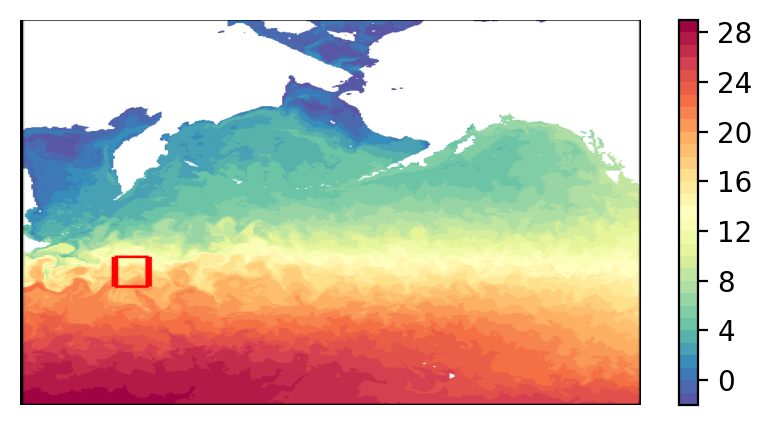

In [4]:
t1 = MLD_1.isel(time=0)
# extract box i,j extents
i_0 = t1.i.values.min()
i_1 = t1.i.values.max()
j_0 = t1.j.values.min()
j_1 = t1.j.values.max()
# j_0 = 800
# j_1 = j_0 + 540
# i_0 = 2500
# i_1 = i_0 + 540

# let's visualize loc of interest
llc_vis = llc.isel(time=2000,face=7, k=14)
fig, ax = plt.subplots(figsize=(5,2.5),dpi=200)
cf = ax.contourf(llc_vis['Theta']['i'], llc_vis['Theta']['j'], llc_vis['Theta'], cmap="Spectral_r",vmin=np.min(llc_vis['Theta']).values,vmax=np.max(llc_vis['Theta']).values, levels = 30)

ax.hlines(y=j_0, xmin=i_0, xmax=i_1, colors='r')
ax.hlines(y=j_1, xmin=i_0, xmax=i_1, colors='r')
ax.vlines(x=i_0, ymin=j_0, ymax=j_1, colors='r')
ax.vlines(x=i_1, ymin=j_0, ymax=j_1, colors='r')

plt.colorbar(cf, ax = ax)
ax.set_xlim(0,4320)

rotate_axes_90_clockwise(ax)

plt.show()

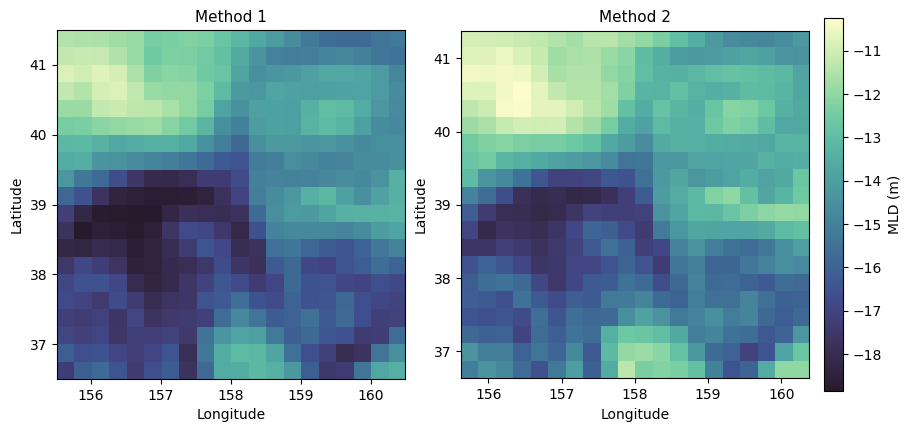

In [5]:
MLD_tiles_1 = MLD_1['MLD_pixels']
MLD_tiles_2 = MLD_2['MLD_pixels']
sep_1 = MLD_tiles_1.isel(time=-1)
sep_2 = MLD_tiles_2.isel(time=-1)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(9, 4.5), constrained_layout=True
)

# shared color limits
vmin = np.nanmin([sep_1.min(), sep_2.min()])
vmax = np.nanmax([sep_1.max(), sep_2.max()])

im1 = ax1.imshow(
    sep_1,
    extent=[
        float(MLD_1.XC.min()), float(MLD_1.XC.max()),
        float(MLD_1.YC.min()), float(MLD_1.YC.max()),
    ],
    origin="lower",
    cmap=cmocean.cm.deep_r,
    vmin=vmin,
    vmax=vmax,
)

im2 = ax2.imshow(
    sep_2,
    extent=[
        float(MLD_2.XC.min()), float(MLD_2.XC.max()),
        float(MLD_2.YC.min()), float(MLD_2.YC.max()),
    ],
    origin="lower",
    cmap=cmocean.cm.deep_r,
    vmin=vmin,
    vmax=vmax,
)

# titles
ax1.set_title("Method 1", fontsize=11)
ax2.set_title("Method 2", fontsize=11)

# labels
for ax in (ax1, ax2):
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect("equal")

# single colorbar
cbar = fig.colorbar(im2, ax=[ax1, ax2], shrink=0.85, pad=0.02)
cbar.set_label("MLD (m)")

plt.show()

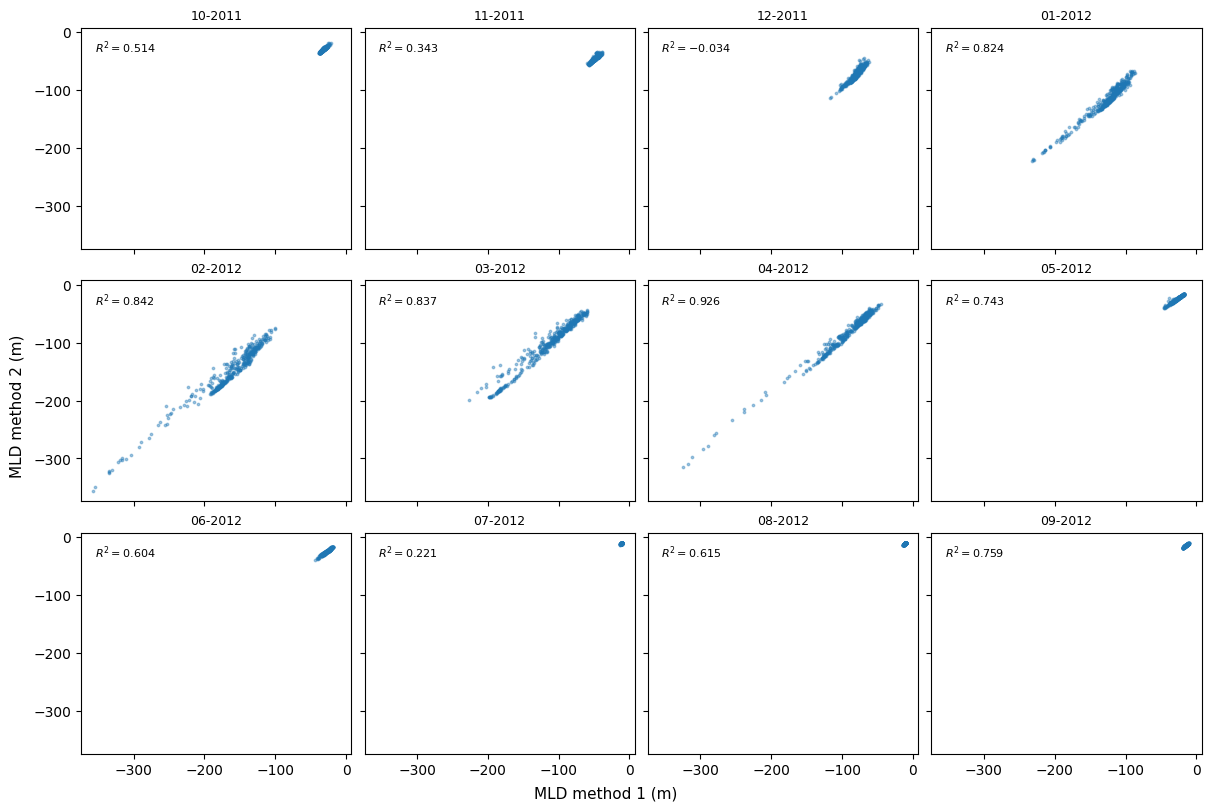

In [10]:
fig, axes = plt.subplots(
    3, 4,
    figsize=(12, 8),
    sharex=True,
    sharey=True,
    constrained_layout=True
)

axes = axes.ravel()

for n, month in enumerate(MLD_tiles_1.time.values):
    ax = axes[n]

    month_str = pd.to_datetime(month).strftime('%m-%Y')

    flat_1 = MLD_tiles_1.isel(time=n).values.flatten()
    flat_2 = MLD_tiles_2.isel(time=n).values.flatten()

    mask = np.isfinite(flat_1) & np.isfinite(flat_2)
    r2 = r2_score(flat_1[mask], flat_2[mask])

    ax.scatter(flat_1, flat_2, s=3, alpha=0.4)

    ax.set_title(month_str, fontsize=9)

    ax.text(
        0.05, 0.95,
        f"$R^2={r2:.3f}$",
        transform=ax.transAxes,
        va="top",
        fontsize=8
    )

# global labels
fig.supxlabel("MLD method 1 (m)", fontsize=11)
fig.supylabel("MLD method 2 (m)", fontsize=11)

plt.show()

Text(0.05, 0.95, '$R^2=-0.034$')

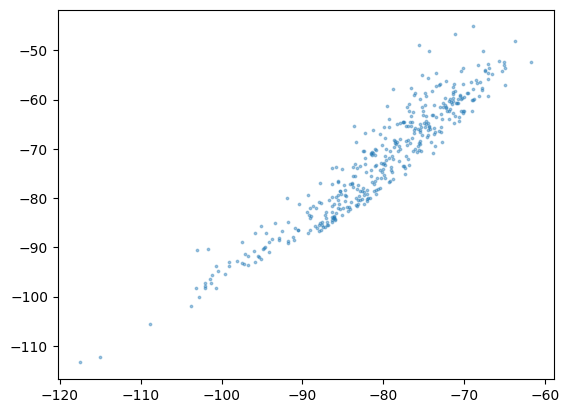

In [22]:


flat_1 = MLD_tiles_1.isel(time=2).values.flatten()
flat_2 = MLD_tiles_2.isel(time=2).values.flatten()

mask = np.isfinite(flat_1) & np.isfinite(flat_2)
r2 = r2_score(flat_1[mask], flat_2[mask])

plt.scatter(flat_1, flat_2, s=3, alpha=0.4)

#ax.set_title(month_str, fontsize=9)

ax.text(
    0.05, 0.95,
    f"$R^2={r2:.3f}$",
    transform=ax.transAxes,
    va="top",
    fontsize=8
)


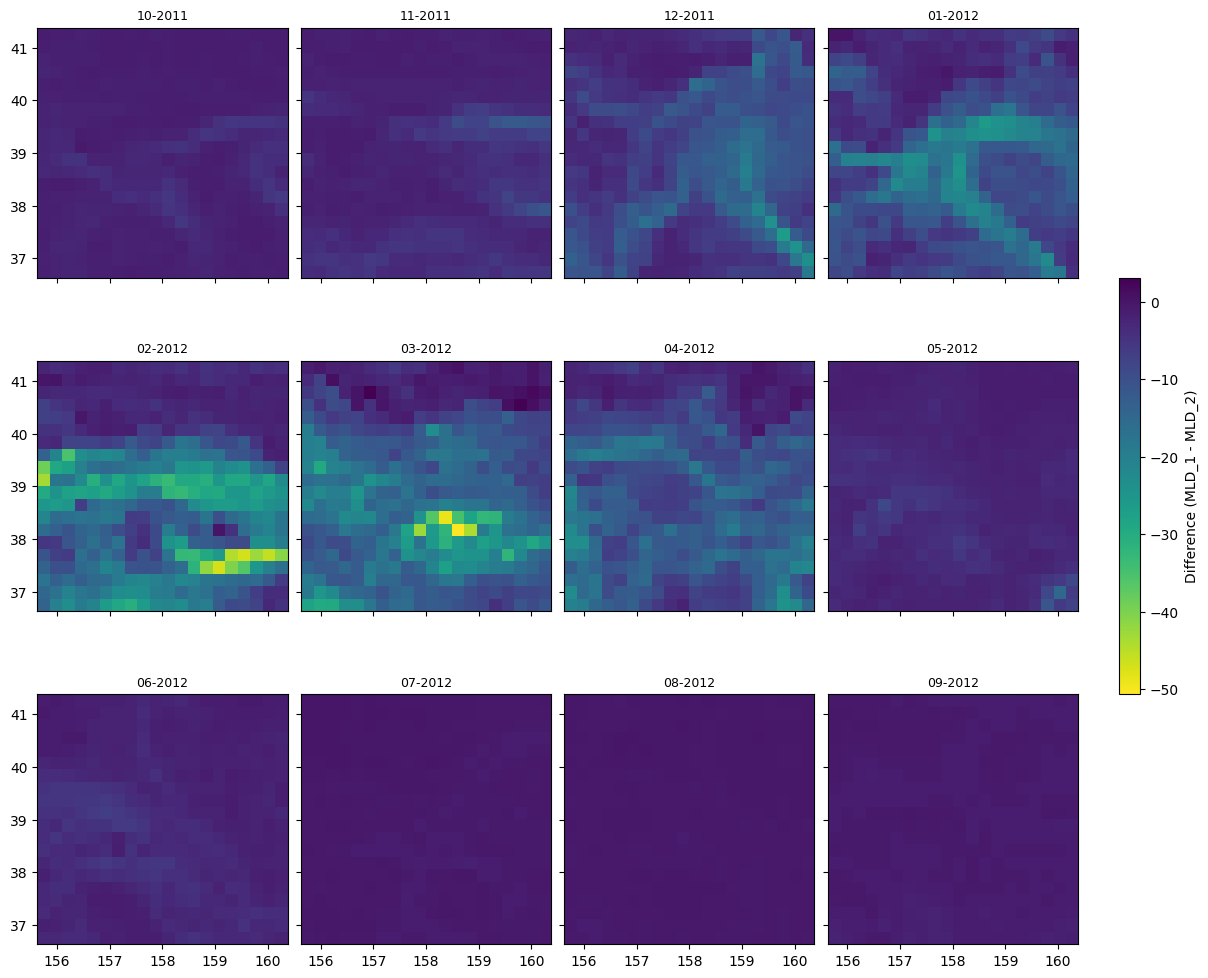

In [11]:
fig, axes = plt.subplots(
    3, 4,
    figsize=(12, 10), # Slightly taller to accommodate cbar
    sharex=True,
    sharey=True,
    constrained_layout=True
)

axes_flat = axes.ravel()

# 1. Determine global min/max for a consistent scale
diff = MLD_tiles_1 - MLD_tiles_2
v_min, v_max = float(diff.min()), float(diff.max())

for n, month in enumerate(MLD_tiles_1.time.values):
    ax = axes_flat[n]
    month_str = pd.to_datetime(month).strftime('%m-%Y')

    # 2. Pass vmin and vmax so the colors are comparable
    im = ax.imshow(
        diff.isel(time=n),
        extent=[
            float(MLD_2.XC.min()), float(MLD_2.XC.max()),
            float(MLD_2.YC.min()), float(MLD_2.YC.max()),
        ],
        origin="lower",
        cmap='viridis_r',
        vmin=v_min, 
        vmax=v_max
    )
    
    ax.set_title(month_str, fontsize=9)

# 3. Create the universal colorbar
# We use 'axes' (the 2D array) to tell matplotlib to steal space from the whole grid
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Difference (MLD_1 - MLD_2)', fontsize=10)

plt.show()

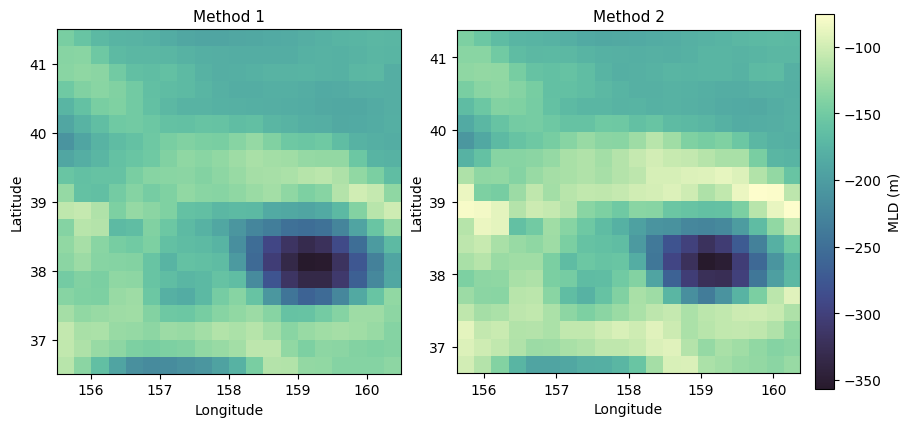

In [12]:
MLD_tiles_1 = MLD_1['MLD_pixels']
MLD_tiles_2 = MLD_2['MLD_pixels']
sep_1 = MLD_tiles_1.isel(time=4)
sep_2 = MLD_tiles_2.isel(time=4)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(9, 4.5), constrained_layout=True
)

# shared color limits
vmin = np.nanmin([sep_1.min(), sep_2.min()])
vmax = np.nanmax([sep_1.max(), sep_2.max()])

im1 = ax1.imshow(
    sep_1,
    extent=[
        float(MLD_1.XC.min()), float(MLD_1.XC.max()),
        float(MLD_1.YC.min()), float(MLD_1.YC.max()),
    ],
    origin="lower",
    cmap=cmocean.cm.deep_r,
    vmin=vmin,
    vmax=vmax,
)

im2 = ax2.imshow(
    sep_2,
    extent=[
        float(MLD_2.XC.min()), float(MLD_2.XC.max()),
        float(MLD_2.YC.min()), float(MLD_2.YC.max()),
    ],
    origin="lower",
    cmap=cmocean.cm.deep_r,
    vmin=vmin,
    vmax=vmax,
)

# titles
ax1.set_title("Method 1", fontsize=11)
ax2.set_title("Method 2", fontsize=11)

# labels
for ax in (ax1, ax2):
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect("equal")

# single colorbar
cbar = fig.colorbar(im2, ax=[ax1, ax2], shrink=0.85, pad=0.02)
cbar.set_label("MLD (m)")

plt.show()

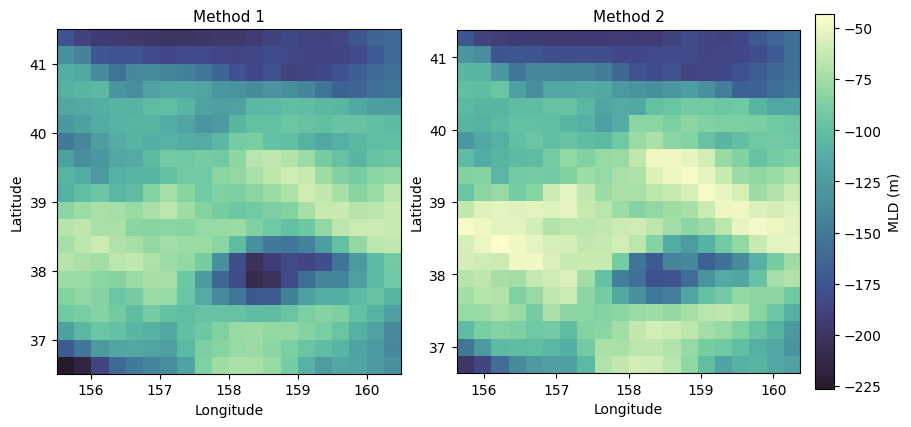

In [13]:
MLD_tiles_1 = MLD_1['MLD_pixels']
MLD_tiles_2 = MLD_2['MLD_pixels']
sep_1 = MLD_tiles_1.isel(time=5)
sep_2 = MLD_tiles_2.isel(time=5)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(9, 4.5), constrained_layout=True
)

# shared color limits
vmin = np.nanmin([sep_1.min(), sep_2.min()])
vmax = np.nanmax([sep_1.max(), sep_2.max()])

im1 = ax1.imshow(
    sep_1,
    extent=[
        float(MLD_1.XC.min()), float(MLD_1.XC.max()),
        float(MLD_1.YC.min()), float(MLD_1.YC.max()),
    ],
    origin="lower",
    cmap=cmocean.cm.deep_r,
    vmin=vmin,
    vmax=vmax,
)

im2 = ax2.imshow(
    sep_2,
    extent=[
        float(MLD_2.XC.min()), float(MLD_2.XC.max()),
        float(MLD_2.YC.min()), float(MLD_2.YC.max()),
    ],
    origin="lower",
    cmap=cmocean.cm.deep_r,
    vmin=vmin,
    vmax=vmax,
)

# titles
ax1.set_title("Method 1", fontsize=11)
ax2.set_title("Method 2", fontsize=11)

# labels
for ax in (ax1, ax2):
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect("equal")

# single colorbar
cbar = fig.colorbar(im2, ax=[ax1, ax2], shrink=0.85, pad=0.02)
cbar.set_label("MLD (m)")

plt.show()

In [23]:
def llc_latlon_box_indices(
    LLC,
    lat_center,
    lon_center,
    degree_extent
):

    half = degree_extent / 2.0

    lat_min = lat_center - half
    lat_max = lat_center + half
    lon_min = lon_center - half
    lon_max = lon_center + half

    XC = LLC["XC"]
    YC = LLC["YC"]

    face_boxes = {}

    for face in XC.face.values:
        xc = XC.sel(face=face)
        yc = YC.sel(face=face)

        # mask points inside the lat/lon box
        mask = (
            (yc >= lat_min) & (yc <= lat_max) &
            (xc >= lon_min) & (xc <= lon_max)
        )

        if not mask.any():
            continue

        # get i/j indices where mask is True
        jj, ii = np.where(mask.values)

        j_start = int(jj.min())
        j_end   = int(jj.max()) + 1
        i_start = int(ii.min())
        i_end   = int(ii.max()) + 1

        face_boxes[int(face)] = (j_start, j_end, i_start, i_end)

    return face_boxes

In [24]:
# gulf stream diagnosing:
loc = 'Gulf'
lat_center = 39
lon_center = -66
extent = 5.0
buffer = 0 # a little greater than 1 allows tile_width to trim to 4 sub-panels of exactly 0.5 x 0.5 deg^2 = 1 x 1 deg^2
degree_extent = extent + buffer
tile_width = 0.25



# temporal extent of the calculation/time series
t_0 = 432
t_1 = t_0 + (365*24) 


# exp name, data_dir
#exp_name = str(slurm_job_name) + f'_({t_0},{t_1})'+f'_{loc}'
#data_dir = '/orcd/data/abodner/002/cody/MLD_per_pixel'

#logger.info(f'Experiment: {exp_name}')

"""
3. open and subset LLC4320
"""


# open LLC4320 and chunk: k should be full-column per chunk for .min(dim="k")
LLC_full = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False, chunks={"time": 96,"k": -1,"i": -1,"j": -1,},)

                    # # select temporal extent, select face
                    # LLC_sub = LLC_face.isel(time=slice(t_0,t_1), face = face, i = slice(i_0,i_1), j = slice(j_0,j_1))[['Theta','Salt','Z','XC','YC','rA']]


    # select [i,j] spatial box, face, temporal subset
boxes = llc_latlon_box_indices(
LLC_full,
lat_center=lat_center,
lon_center=lon_center,
degree_extent=degree_extent)

subs = []
for face, (j0, j1, i0, i1) in boxes.items():
    subs.append(
        LLC_full.isel(face=face, j=slice(j0, j1), i=slice(i0, i1))
    )

LLC_sub = xr.concat(subs, dim="face")

# select temporal extent
LLC_sub = LLC_sub.isel(time=2000)[['Theta','Salt','Z','XC','YC','rA']]


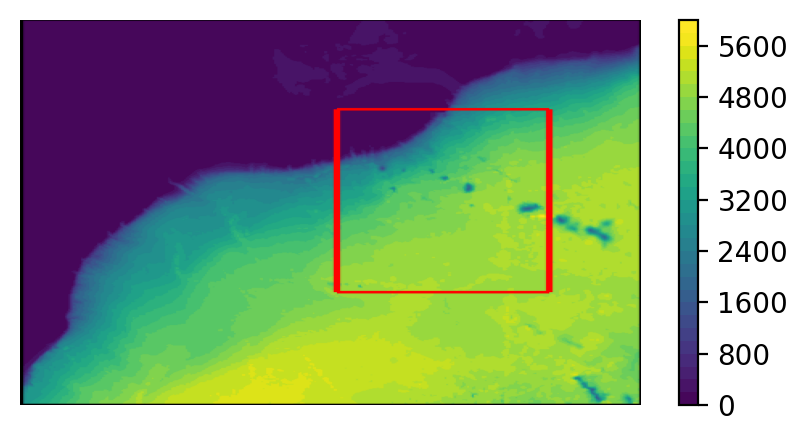

In [30]:
t1 = LLC_sub
# extract box i,j extents
i_0 = t1.i.values.min()
i_1 = t1.i.values.max()
j_0 = t1.j.values.min()
j_1 = t1.j.values.max()
# j_0 = 800
# j_1 = j_0 + 540
# i_0 = 2500
# i_1 = i_0 + 540

# let's visualize loc of interest
llc_vis = llc.isel(time=2000,face=10, k=14, i=slice(2500,3200), j =slice(2500,3200))
fig, ax = plt.subplots(figsize=(5,2.5),dpi=200)
cf = ax.contourf(llc_vis['Depth']['i'], llc_vis['Depth']['j'], llc_vis['Depth'], cmap="viridis",vmin=np.min(llc_vis['Depth']).values,vmax=np.max(llc_vis['Depth']).values, levels = 30)

ax.hlines(y=j_0, xmin=i_0, xmax=i_1, colors='r')
ax.hlines(y=j_1, xmin=i_0, xmax=i_1, colors='r')
ax.vlines(x=i_0, ymin=j_0, ymax=j_1, colors='r')
ax.vlines(x=i_1, ymin=j_0, ymax=j_1, colors='r')

plt.colorbar(cf, ax = ax)
rotate_axes_90_clockwise(ax)
plt.show()

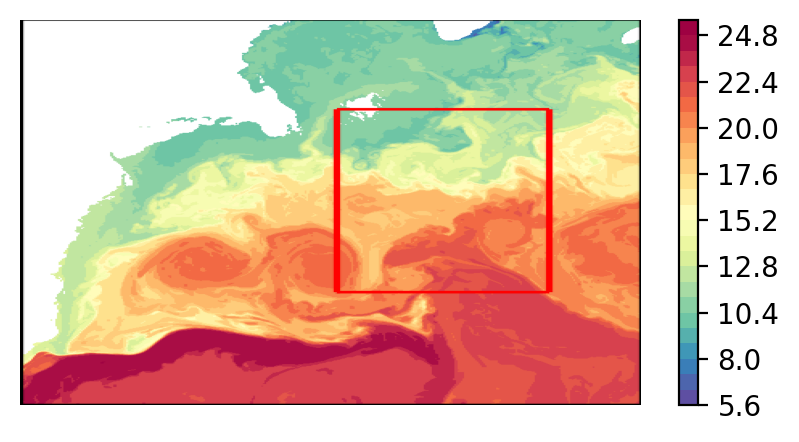

In [32]:
t1 = LLC_sub
# extract box i,j extents
i_0 = t1.i.values.min()
i_1 = t1.i.values.max()
j_0 = t1.j.values.min()
j_1 = t1.j.values.max()
# j_0 = 800
# j_1 = j_0 + 540
# i_0 = 2500
# i_1 = i_0 + 540

# let's visualize loc of interest
llc_vis = llc.isel(time=2000,face=10, k=14, i=slice(2500,3200), j =slice(2500,3200))
fig, ax = plt.subplots(figsize=(5,2.5),dpi=200)
cf = ax.contourf(llc_vis['Theta']['i'], llc_vis['Theta']['j'], llc_vis['Theta'], cmap="Spectral_r",vmin=np.min(llc_vis['Theta']).values,vmax=np.max(llc_vis['Theta']).values, levels = 30)

ax.hlines(y=j_0, xmin=i_0, xmax=i_1, colors='r')
ax.hlines(y=j_1, xmin=i_0, xmax=i_1, colors='r')
ax.vlines(x=i_0, ymin=j_0, ymax=j_1, colors='r')
ax.vlines(x=i_1, ymin=j_0, ymax=j_1, colors='r')

plt.colorbar(cf, ax = ax)
rotate_axes_90_clockwise(ax)
plt.show()

In [ ]:
# first define a helper function to rotate plots for N-S/vertical alignment
def rotate_axes_90_clockwise(ax):
    """
    Robustly rotate a Matplotlib Axes 90 degrees clockwise by:
      - rendering the figure to an RGBA buffer,
      - cropping the pixels belonging to the given Axes,
      - rotating the image 90 deg clockwise,
      - placing the rotated image back into the figure at the same axes position,
      - removing the original Axes.

    Notes:
    - This rasterizes the axis contents (the result is an image, not vector art).
    - Colorbars or other axes that live outside the target `ax` are left alone.
    - Works reliably for full grids or arbitrary subsets.
    """
    fig = ax.figure

    # Force draw so renderer & sizes are correct
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    # Get pixel bbox of the axes (in display coordinates) via renderer-aware call
    bbox = ax.get_window_extent(renderer=renderer)  # Bbox in display (pixel) coords

    # Grab the full figure RGBA buffer (H x W x 4)
    buf = np.asarray(renderer.buffer_rgba())  # returns an (H,W,4) uint8 array

    H, W = buf.shape[0], buf.shape[1]

    # Convert bbox to integer pixel coords and crop.
    # Note: Bbox y coords are in display coordinates with origin at lower-left.
    x0, x1 = int(np.floor(bbox.x0)), int(np.ceil(bbox.x1))
    y0, y1 = int(np.floor(bbox.y0)), int(np.ceil(bbox.y1))

    # Convert to numpy row indices (origin at top-left)
    row0 = max(0, H - y1)
    row1 = min(H, H - y0)
    col0 = max(0, x0)
    col1 = min(W, x1)

    if row1 <= row0 or col1 <= col0:
        raise RuntimeError("Calculated zero-size axes crop — renderer/coords inconsistent.")

    axes_img = buf[row0:row1, col0:col1, :].copy()  # copy to be safe

    # Rotate 90 degrees clockwise. np.rot90 rotates counterclockwise, so use k=-1 (or k=3).
    rotated = np.rot90(axes_img, k=-1)

    # Create a new axes in the same figure position (figure coords) and show the rotated image.
    # We must compute the original axes position in figure coordinates:
    fig_x0, fig_y0, fig_w, fig_h = ax.get_position().bounds

    # Add overlaid axes and show the rotated image
    new_ax = fig.add_axes([fig_x0, fig_y0, fig_w, fig_h], anchor='C')  # same place
    new_ax.imshow(rotated, origin='upper', aspect='auto')
    new_ax.set_axis_off()

    # Remove the original axes (so only rotated image remains)
    fig.delaxes(ax)

    # Force redraw
    fig.canvas.draw()
    return new_ax

# function to get i,j indices from target lat/lon vals
def i_j_from_lat_lon(coord_centers, num_boxes, coord_min):
    i = []
    j = []
    for box in range(int(num_boxes)):
        # get lat/lon in increments
        target = coord_min + 0.1 * box

        # get index closest to lat/lon targets
        dist = np.abs(coord_centers - target)
        flat_idx = np.nanargmin(dist)
        i_, j_ = np.unravel_index(flat_idx, coord_centers.shape)
        
        i.append(int(i_)), j.append(int(j_))
    return i, j

# function to get lat/lon vals from i, j indices
def lat_lon_from_i_j(LLC):
    lats = []
    lons = []
    lats.append(LLC['YC'][0,:].values)
    lons.append(LLC['XC'][:,0].values)

    return lats, lons

In [ ]:
data_dir = '/orcd/data/abodner/002/cody/MLD_per_pixel'
data1 = 'MLD_test_face7_(432,9192)_((2000, 2540))'
data2 ='MLD_2_face7_(2640,3384)_0.25_((2000, 2540))'
data3 = 'MLD_3_face7_(2640,3384)_0.25_((2000, 2540))'
MLD_1 = xr.open_zarr(f'{data_dir}/{data1}.zarr',consolidated=False)
MLD_2 = xr.open_zarr(f'{data_dir}/{data2}.zarr',consolidated=False)
MLD_3 = xr.open_zarr(f'{data_dir}/{data3}.zarr',consolidated=False)
llc = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

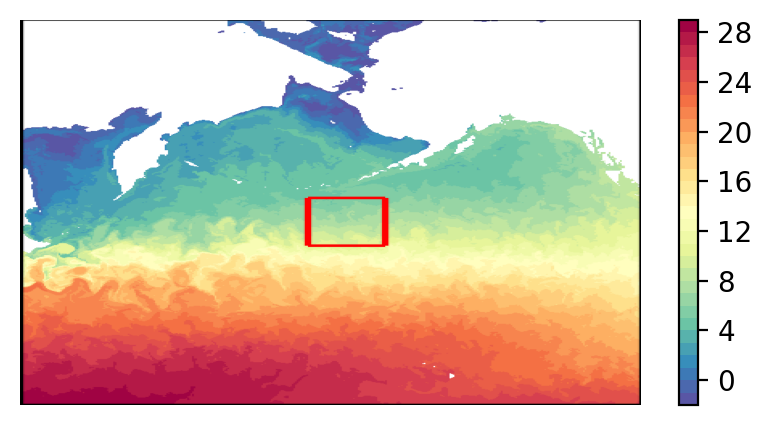

In [ ]:
t1 = MLD_1.isel(time=0)
# extract box i,j extents
i_0 = t1.i.values.min()
i_1 = t1.i.values.max()
j_0 = t1.j.values.min()
j_1 = t1.j.values.max()

# let's visualize loc of interest
llc_vis = llc.isel(time=2000,face=7, k=14)
fig, ax = plt.subplots(figsize=(5,2.5),dpi=200)
cf = ax.contourf(llc_vis['Theta']['i'], llc_vis['Theta']['j'], llc_vis['Theta'], cmap="Spectral_r",vmin=np.min(llc_vis['Theta']).values,vmax=np.max(llc_vis['Theta']).values, levels = 30)

ax.hlines(y=j_0, xmin=i_0, xmax=i_1, colors='r')
ax.hlines(y=j_1, xmin=i_0, xmax=i_1, colors='r')
ax.vlines(x=i_0, ymin=j_0, ymax=j_1, colors='r')
ax.vlines(x=i_1, ymin=j_0, ymax=j_1, colors='r')

plt.colorbar(cf, ax = ax)
ax.set_xlim(0,4320)

rotate_axes_90_clockwise(ax)

plt.show()

In [ ]:
# take temporal average of MLD1, grab jan
MLD_jan = MLD_1.resample(time="MS").mean().isel(time=3).compute()

In [ ]:

# subset into tiles:
"""
SUBSET INTO TILES
"""

# subset into tiles, weight by surface area   
tile_width = 0.25
YC = MLD_jan.YC 
XC = MLD_jan.XC 
lat_min = float(YC.min()) 
lat_max = float(YC.max()) 
lon_min = float(XC.min()) 
lon_max = float(XC.max())

# compute tile labels eagerly (small arrays)
tile_lat = ((MLD_jan.YC - lat_min) / tile_width).astype("int32").compute()
tile_lon = ((MLD_jan.XC - lon_min) / tile_width).astype("int32").compute()

# stack dataset
MLD_1_tile = MLD_jan.assign_coords(
    tile_lat=tile_lat,
    tile_lon=tile_lon,
).stack(cell=("j","i"))

# stack area
area_cell = MLD_jan.rA.stack(cell=("j","i"))

# attach tile labels to area
area_cell = area_cell.assign_coords(
    tile_lat=MLD_1_tile.tile_lat,
    tile_lon=MLD_1_tile.tile_lon,
)

num = (MLD_1_tile * area_cell).groupby(["tile_lat","tile_lon"]).sum("cell")
den = area_cell.groupby(["tile_lat","tile_lon"]).sum("cell")

MLD_1_tiles = num / den
MLD_1_pixels = MLD_jan

In [ ]:

MLD_2 = MLD_2.isel(time=0)
MLD_3 = MLD_3.isel(time=0)

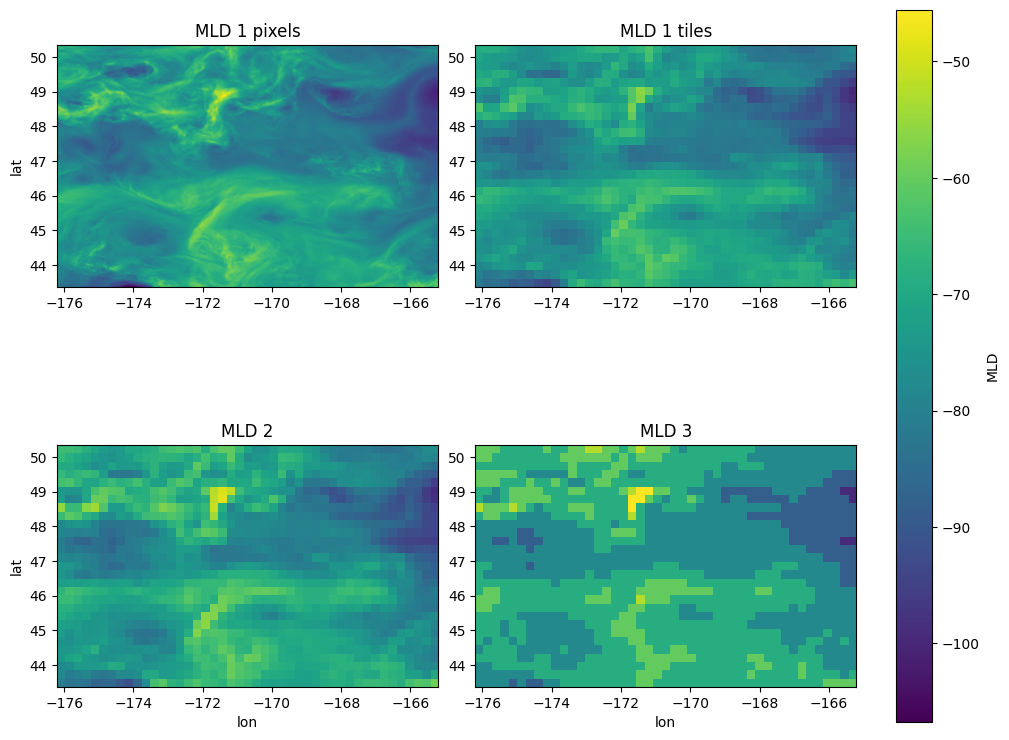

In [22]:
vmin = np.min([
    MLD_1_tiles.MLD_pixels.min(),
    MLD_1_pixels.MLD_pixels.min(),
    MLD_2.MLD_pixels.min(),
    MLD_3.MLD_pixels.min()
])

vmax = np.max([
    MLD_1_tiles.MLD_pixels.max(),
    MLD_1_pixels.MLD_pixels.max(),
    MLD_2.MLD_pixels.max(),
    MLD_3.MLD_pixels.max()
])

fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)

# Physical coordinates on axes (assuming same grid for all)
extent = [MLD_1_tiles.XC.min(), MLD_1_tiles.XC.max(),
          MLD_1_tiles.YC.min(), MLD_1_tiles.YC.max()]

# Row 1
im1 = axes[0, 1].imshow(MLD_1_tiles.MLD_pixels, extent=extent, origin="lower",
                        vmin=vmin, vmax=vmax)
axes[0, 1].set_title("MLD 1 tiles")

im0 = axes[0, 0].imshow(np.rot90(MLD_1_pixels.MLD_pixels, 1), extent=extent, origin="lower",
                        vmin=vmin, vmax=vmax)
axes[0, 0].set_title("MLD 1 pixels")

# Row 2
im2 = axes[1, 0].imshow(MLD_2.MLD_pixels, extent=extent, origin="lower",
                        vmin=vmin, vmax=vmax)
axes[1, 0].set_title("MLD 2")

im3 = axes[1, 1].imshow(MLD_3.MLD_pixels, extent=extent, origin="lower",
                        vmin=vmin, vmax=vmax)
axes[1, 1].set_title("MLD 3")

# Shared colorbar (use last handle)
cbar = fig.colorbar(im3, ax=axes.ravel().tolist(), shrink=0.9)
cbar.set_label("MLD")

# Axis labels (only outer to keep clean)
for ax in axes[1, :]:
    ax.set_xlabel("lon")
for ax in axes[:, 0]:
    ax.set_ylabel("lat")

plt.show()

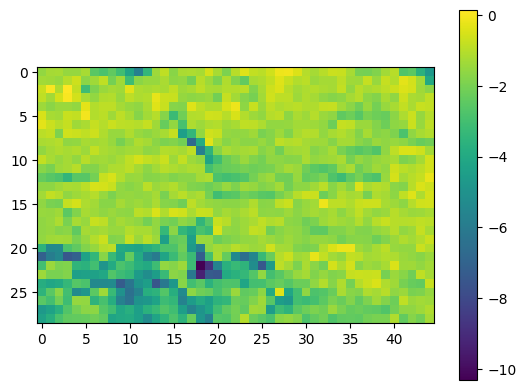

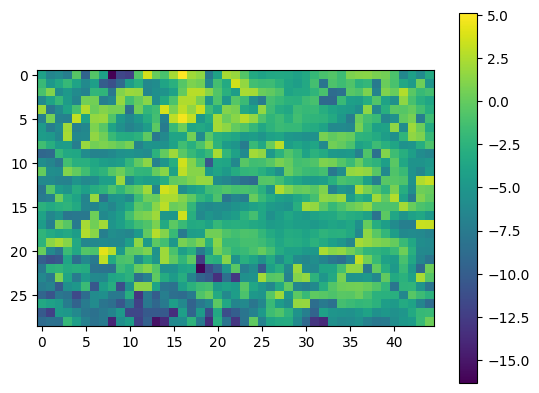

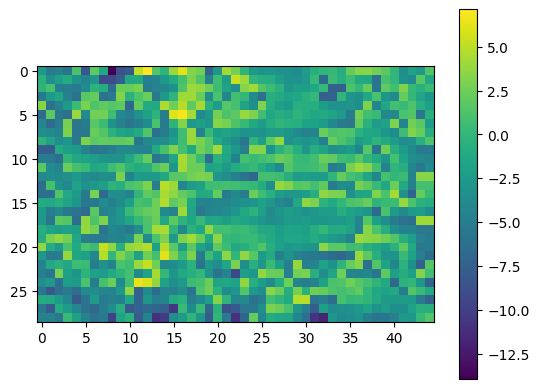

In [26]:
plt.imshow(MLD_1_tiles.MLD_pixels - MLD_2.MLD_pixels)
plt.colorbar()
plt.show()

plt.imshow(MLD_1_tiles.MLD_pixels - MLD_3.MLD_pixels)
plt.colorbar()
plt.show()

plt.imshow(MLD_2.MLD_pixels - MLD_3.MLD_pixels)
plt.colorbar()

In [ ]:
data_dir = '/orcd/data/abodner/002/cody/MLD_per_pixel'
data1 = 'MLD_1_face1_(432,9192)_(Agulhas)'
data2 ='MLD_2_face1_(432,9192)_(Agulhas)'
data3 = 'MLD_3_face1_(432,9192)_(Agulhas)'
MLD_1 = xr.open_zarr(f'{data_dir}/{data1}.zarr',consolidated=False)
MLD_2 = xr.open_zarr(f'{data_dir}/{data2}.zarr',consolidated=False)
MLD_3 = xr.open_zarr(f'{data_dir}/{data3}.zarr',consolidated=False)
llc = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)


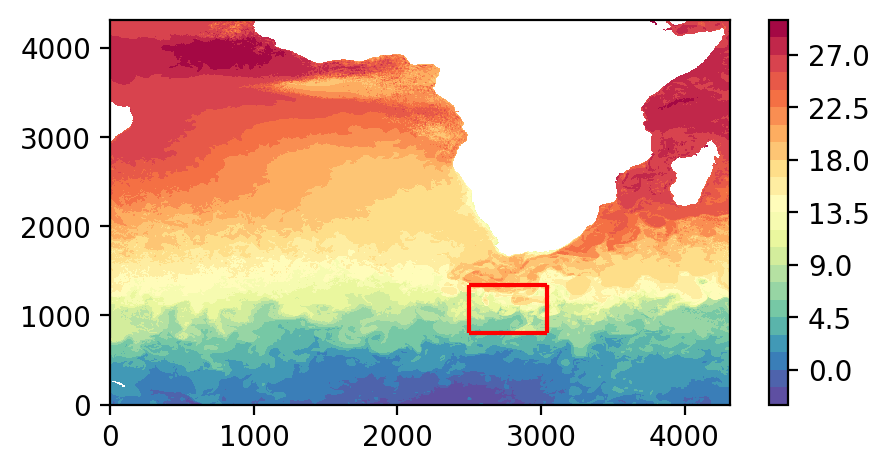

In [16]:
t1 = MLD_1.isel(time=0)
# extract box i,j extents
j_0 = 800
j_1 = j_0 + 540
i_0 = 2500
i_1 = i_0 + 540

# let's visualize loc of interest
llc_vis = llc.isel(time=2000,face=1, k=14)
fig, ax = plt.subplots(figsize=(5,2.5),dpi=200)
cf = ax.contourf(llc_vis['Theta']['i'], llc_vis['Theta']['j'], llc_vis['Theta'], cmap="Spectral_r",vmin=np.min(llc_vis['Theta']).values,vmax=np.max(llc_vis['Theta']).values, levels = 30)

ax.hlines(y=j_0, xmin=i_0, xmax=i_1, colors='r')
ax.hlines(y=j_1, xmin=i_0, xmax=i_1, colors='r')
ax.vlines(x=i_0, ymin=j_0, ymax=j_1, colors='r')
ax.vlines(x=i_1, ymin=j_0, ymax=j_1, colors='r')

plt.colorbar(cf, ax = ax)
ax.set_xlim(0,4320)

plt.show()

In [ ]:
# take temporal average of MLD1, grab jan
MLD_jan = MLD_1.resample(time="MS").mean().isel(time=3).compute()
# subset into tiles:
"""
SUBSET INTO TILES
"""

# subset into tiles, weight by surface area   
tile_width = 0.25
YC = MLD_jan.YC 
XC = MLD_jan.XC 
lat_min = float(YC.min()) 
lat_max = float(YC.max()) 
lon_min = float(XC.min()) 
lon_max = float(XC.max())

# compute tile labels eagerly (small arrays)
tile_lat = ((MLD_jan.YC - lat_min) / tile_width).astype("int32").compute()
tile_lon = ((MLD_jan.XC - lon_min) / tile_width).astype("int32").compute()

# stack dataset
MLD_1_tile = MLD_jan.assign_coords(
    tile_lat=tile_lat,
    tile_lon=tile_lon,
).stack(cell=("j","i"))

# stack area
area_cell = MLD_jan.rA.stack(cell=("j","i"))

# attach tile labels to area
area_cell = area_cell.assign_coords(
    tile_lat=MLD_1_tile.tile_lat,
    tile_lon=MLD_1_tile.tile_lon,
)

num = (MLD_1_tile * area_cell).groupby(["tile_lat","tile_lon"]).sum("cell")
den = area_cell.groupby(["tile_lat","tile_lon"]).sum("cell")

MLD_1_tiles = num / den
MLD_1_pixels = MLD_jan
MLD_2 = MLD_2.isel(time=0)
MLD_3 = MLD_3.isel(time=0)

In [ ]:
vmin = np.min([
    MLD_1_tiles.MLD_pixels.min(),
    MLD_1_pixels.MLD_pixels.min(),
    MLD_2.MLD_pixels.min(),
    MLD_3.MLD_pixels.min()
])

vmax = np.max([
    MLD_1_tiles.MLD_pixels.max(),
    MLD_1_pixels.MLD_pixels.max(),
    MLD_2.MLD_pixels.max(),
    MLD_3.MLD_pixels.max()
])

fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)

# Physical coordinates on axes (assuming same grid for all)
extent = [MLD_1_tiles.XC.min(), MLD_1_tiles.XC.max(),
          MLD_1_tiles.YC.min(), MLD_1_tiles.YC.max()]

# Row 1
im0 = axes[0, 0].imshow(MLD_1_tiles.MLD_pixels, extent=extent, origin="lower",
                        vmin=vmin, vmax=vmax)
axes[0, 0].set_title("MLD 1 tiles")

im1 = axes[0, 1].imshow(MLD_1_pixels.MLD_pixels, extent=extent, origin="lower",
                        vmin=vmin, vmax=vmax)
axes[0, 1].set_title("MLD 1 pixels")

# Row 2
im2 = axes[1, 0].imshow(MLD_2.MLD_pixels, extent=extent, origin="lower",
                        vmin=vmin, vmax=vmax)
axes[1, 0].set_title("MLD 2")

im3 = axes[1, 1].imshow(MLD_3.MLD_pixels, extent=extent, origin="lower",
                        vmin=vmin, vmax=vmax)
axes[1, 1].set_title("MLD 3")

# Shared colorbar (use last handle)
cbar = fig.colorbar(im3, ax=axes.ravel().tolist(), shrink=0.9)
cbar.set_label("MLD")

# Axis labels (only outer to keep clean)
for ax in axes[1, :]:
    ax.set_xlabel("lon")
for ax in axes[:, 0]:
    ax.set_ylabel("lat")

plt.show()